In [8]:
#THIS TRAINS A HYDROLOGICAL MODEL LOCALLY, USING ERA5 AND GLOFAS DATA TO PREDICT GLOFAS DATA
import sys
sys.path.append("../")

#HYPERPARAMETERS
days_intake_length = 60
forecast_day = 14



In [49]:
#LIBRARY IMPORTS
from functions.floodmodel_utils import reshape_scalar_predictand
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster


#Connecting to a cluster to be able to run the code locally/on the cloud
client = Client()
#Use this line of code if you want to run the code on the cluster
# client = Client("tcp://169.45.50.121:8786")



/root/miniconda3/envs/main/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [50]:
print(client.scheduler_info()['services'])


{'dashboard': 36843}


In [59]:
ds = xr.open_dataset('../features_xy.nc')
ds

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    cp          (time) float32 ...
    lsp         (time) float32 ...
    swvl1       (time) float32 ...
    ro          (time) float32 ...
    sd          (time) float32 ...
    sd_diff     (time) float32 ...
    lsp-4-11    (time) float32 ...
    lsp-12-25   (time) float32 ...
    lsp-26-55   (time) float32 ...
    lsp-56-180  (time) float32 ...
    lsp-1       (time) float32 ...
    lsp-2       (time) float32 ...
    lsp-3       (time) float32 ...
    cp-1        (time) float32 ...
    cp-2        (time) float32 ...
    cp-3        (time) float32 ...
    dis         (time) float64 ...
    dis_diff    (time) float64 ...

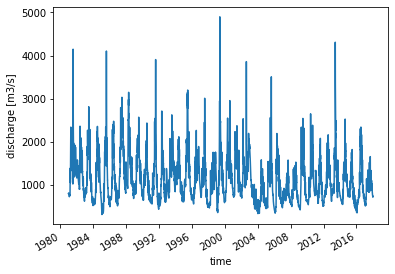

In [60]:
ds['dis'].plot()

In [61]:
mean_discharge = ds.mean(dim ='time')['dis']
mean_discharge

<xarray.DataArray 'dis' ()>
array(1125.81431942)

In [64]:
mask = ds['dis'] > mean_discharge * 1.5
ds1 = ds['dis'].where(mask, drop=True)

ds2 = ds['dis'].where(mask)

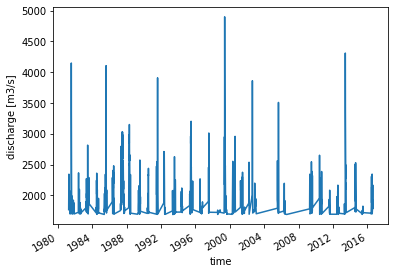

In [69]:
ds1.plot()

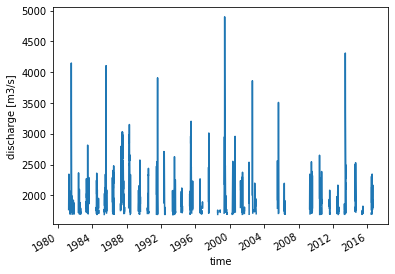

In [70]:
ds2.plot()

In [6]:
#Selecting our X and y values from the dataset. Y has the river discharge values
y_orig = ds['dis']
y = y_orig.copy()
X = ds.drop(['dis', 'dis_diff'])


Xda, yda = reshape_scalar_predictand(X, y)

In [7]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))


X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

In [8]:
import numpy as np

#Applying feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_train_scaled = sc.fit_transform(X_train)
sc2 = MinMaxScaler(feature_range=(0,1))
y_train_scaled = sc2.fit_transform(y_train.values.reshape(-1,1))
X_train = []
y_train_array = []

#Iterating through each feature, shifting the time for each feature, and appending the time-shifted feature array to X_train for a total of 16 times
for n in range(16):
    feature_array = []

    for i in range(60, len(X_train_scaled)):
        feature_array.append(X_train_scaled[i - days_intake_length:i, n])


    X_train.append(feature_array)

y_feature_array = []

for i in range(days_intake_length, len(y_train_scaled)):
    y_feature_array.append(y_train_scaled[i-days_intake_length:i,0])

X_train.append(y_feature_array)

#Creating the transformed y_train array which is shifted by 60 days
for i in range(days_intake_length, len(y_train_scaled)):
    y_train_array.append(y_train_scaled[i,0])

#Transforming the list into numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train_array)

X_train.shape
# (17, 8862, 60)

#Reshaping new_X_train to be supported as an input format for the LSTM
X_train = np.reshape(X_train, (X_train.shape[1], X_train.shape[2], X_train.shape[0]))

In [9]:
X_train.shape

(8862, 60, 17)

In [10]:
y_train

array([0.28618564, 0.28147932, 0.27142747, ..., 0.03184796, 0.0309798 ,
       0.03014713])

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.core import Dropout


regressor = Sequential()

regressor.add(LSTM(units=2000, return_sequences= True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=2000, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=2000, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=2000))
regressor.add(Dropout(0.1))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = regressor.fit(X_train, y_train, epochs=14, batch_size=200)

In [ ]:
y_train.shape

In [ ]:
#Visualizing the loss functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training', 'Validation'])
ax.set_yscale('log')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(regressor.predict(X_train))

In [ ]:
history.history

In [ ]:
regressor.predict(X_train)

In [ ]:
regressor_yaml = regressor.to_yaml()
with open("./featureLSTM.yaml", "w") as yaml_file:
    yaml_file.write(regressor_yaml)
# serialize weights to HDF5
regressor.save_weights("./featureLSTM.h5")
#Seialize feature scaling weights

In [ ]:
#LATER ON...LOADING THE MODEL
regressor_model = open('./featureLSTM.yaml', 'r').read()
from keras.models import model_from_yaml
loaded_regressor = model_from_yaml(regressor_model)
loaded_regressor.load_weights('./featureLSTM.h5')
regressor = loaded_regressor


In [ ]:

#Predicting on validation data
X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

#Fitting the test values on the model
X_total = np.concatenate((X_train, X_valid))
#To test our model on the test set, we will need to use part of the training set. More specifically, since our model has been trained on the
#60 previous days, we will need exactly 60 days out of the training set, in addition to all of the test set.
X_inputs = X_total[len(X_total)-len(X_valid)-days_intake_length:]

#Scaling the input data
X_inputs = sc.transform(X_inputs)


y_total = np.concatenate((y_train, y_valid))
y_inputs = y_total[len(y_total)-len(y_valid)-days_intake_length:]

y_inputs = sc2.transform(y_inputs.reshape(-1,1))
#Empty array in which we will append values
X_valid = []
y_valid_feature_array =[]

#Iterating through the 16 features and appending them to X_valid
for n in range(16):
    feature_array = []
    for i in range(days_intake_length, len(X_inputs)):
        #Creates a 2d list with each list inside the list representing a 60 day time interval of the variable
        feature_array.append(X_inputs[i-days_intake_length:i, n])

    #Appending each feature to the final X_valid list
    X_valid.append(feature_array)



for i in range(60, len(X_inputs)):
    y_valid_feature_array.append(y_inputs[i-60:i,0])


X_valid.append(y_valid_feature_array)

X_valid = np.array(X_valid)

#This reshape is necessary since this is the input format the model expects
X_valid = np.reshape(X_valid, (X_valid.shape[1], X_valid.shape[2], X_valid.shape[0]))

y_pred_valid = regressor.predict(X_valid)
# y_pred_valid = sc.inverse_transform(y_pred_valid)
y_pred_valid = sc2.inverse_transform(y_pred_valid)




#Model predicting on test data

#I am calling this again because I will require the original datasets that have not been manipulated in order to apply transformation again
X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

#Making the predictions on the test set (where there was a flood event)
X_total = np.concatenate((X_valid, X_test))
#To test our model on the test set, we will need to use part of the training set. More specifically, since our model has been trained on the
#60 previous days, we will need exactly 60 days out of the training set, in addition to all of the test set.
X_inputs = X_total[len(X_total)-len(X_test)-days_intake_length:]

#Scaling the input data
X_inputs = sc.transform(X_inputs)

#Empty array in which we will append values
X_test = []
y_total = np.concatenate((y_valid, y_test))
y_inputs = y_total[len(y_total)-len(y_test)-days_intake_length:]

y_inputs = sc2.transform(y_inputs.reshape(-1,1))
#Empty array in which we will append values
X_test = []
y_test_feature_array =[]

#Iterating through the 16 features and appending them to X_valid
for n in range(16):
    feature_array = []
    for i in range(days_intake_length, len(X_inputs)):
        #Creates a 2d list with each list inside the list representing a 60 day time interval of the variable
        feature_array.append(X_inputs[i-days_intake_length:i, n])

    #Appending each feature to the final X_valid list
    X_test.append(feature_array)

for i in range(60, len(X_inputs)):
    y_test_feature_array.append(y_inputs[i-60:i,0])


X_valid.append(y_valid_feature_array)

X_test = np.array(X_test)

#This reshape is necessary since this is the input format the model expects
X_test = np.reshape(X_test, (X_test.shape[1], X_test.shape[2], X_test.shape[0]))



In [ ]:
y_pred_test = regressor.predict(X_test)

/root/miniconda3/envs/main/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


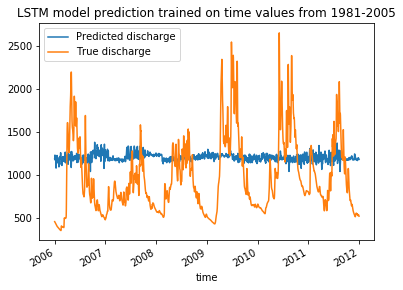

In [12]:
import matplotlib.pyplot as plt

#Plotting the validation predicted values
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
y_pred_valid_xr = xr.DataArray(y_pred_valid.reshape(-1), dims=('time'), coords={'time': X_valid.time.values})
y_pred_valid_xr.plot(label = "Predicted discharge")
#Plotting the real validation values
y_valid_xr = xr.DataArray(y_valid, dims=('time'), coords={'time': X_valid.time.values})
y_valid_xr.plot(label="True discharge")
plt.title('LSTM model prediction trained on time values from 1981-2005')
plt.legend(loc='upper left')